# Estimación de pasajeros

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from datetime import datetime, timedelta


In [2]:
#datos
data_raw = pd.read_excel("datos_transporte.xlsx", sheet_name='datos ln')
data = data_raw.iloc[:, 1:5]

In [3]:
#serie
fecha_inicio = pd.Timestamp(year=2021, month=11, day=1)
fecha_fin = pd.Timestamp(year=2025, month=1, day=1)
fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='MS')
data.index = fechas[:len(data)]

In [4]:
#pax
pax = data['pax']

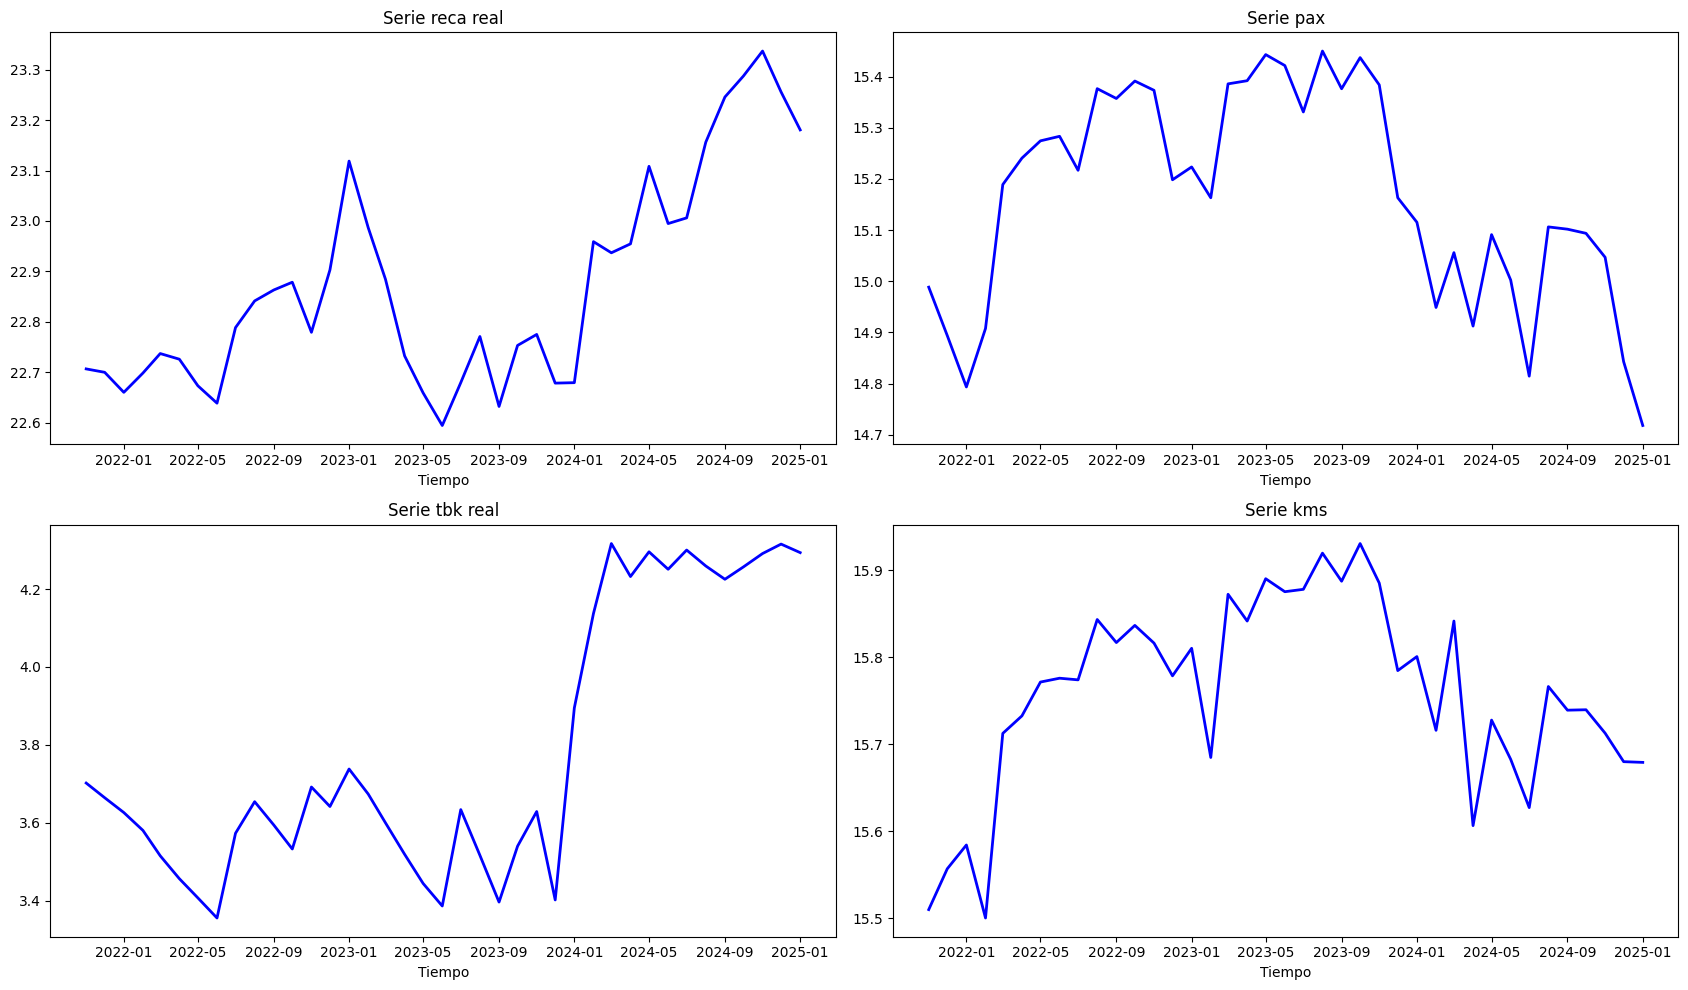

In [8]:
#graphs
plt.figure(figsize=(17, 10))
for i, col in enumerate(data.columns):
    plt.subplot(2, 2, i+1)
    plt.plot(data.index, data[col], color='blue', linewidth=2)
    plt.title(f'Serie {col}')
    plt.xlabel('Tiempo')

plt.tight_layout()
plt.show()

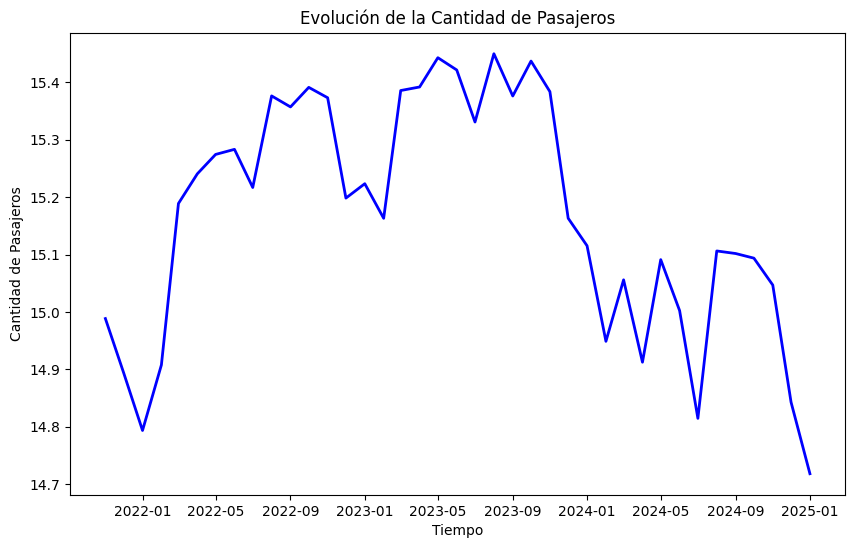

In [6]:
#graph pax
plt.figure(figsize=(10, 6))
plt.plot(pax.index, pax, color='blue', linewidth=2)
plt.title('Evolución de la Cantidad de Pasajeros')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasajeros')
plt.show()

In [13]:
#adf
pax_diff1 = pax.diff().dropna() 
adf_result1 = adfuller(pax_diff1)
print('Resultado de la prueba ADF en la serie diferenciada:')
print(f'Estadístico ADF: {adf_result1[0]}')
print(f'p-value: {adf_result1[1]}')
print(f'Valores críticos: {adf_result1[4]}')


Resultado de la prueba ADF en la serie diferenciada:
Estadístico ADF: -2.6431129961507627
p-value: 0.08440997394126026
Valores críticos: {'1%': np.float64(-3.6699197407407405), '5%': np.float64(-2.9640707407407407), '10%': np.float64(-2.621171111111111)}


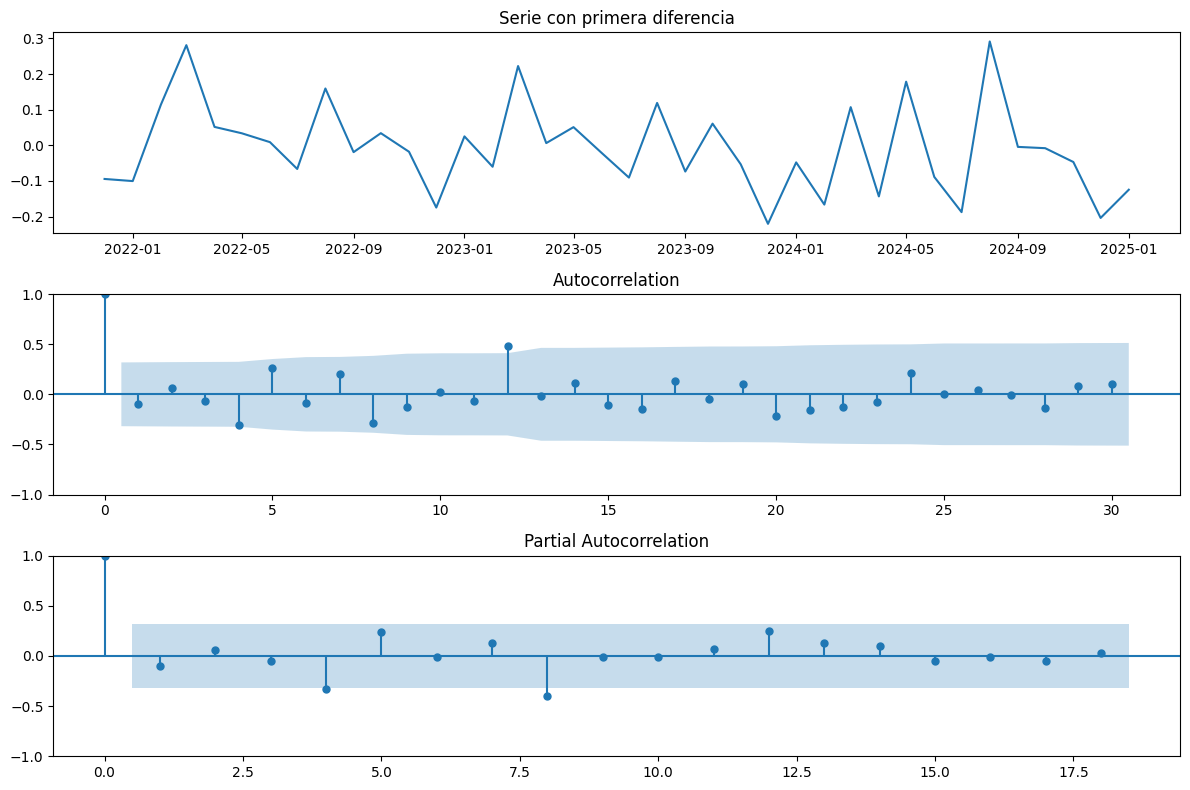

In [14]:
#graph adf
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(pax_diff1)
plt.title('Serie con primera diferencia')
plt.subplot(312)
plot_acf(pax_diff1, ax=plt.gca(), lags=30)
plt.subplot(313) 
plot_pacf(pax_diff1, ax=plt.gca(), lags=18)
plt.tight_layout()
plt.show()

In [ ]:
#arima
model1 = ARIMA(pax, order=(8, 1, 12))
resultados = model1.fit()
print(resultados.summary())

C:\Users\rafah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    pax   No. Observations:                   39
Model:                ARIMA(8, 1, 12)   Log Likelihood                  41.028
Date:                dom, 16 mar 2025   AIC                            -40.056
Time:                        23:19:50   BIC                             -5.666
Sample:                    11-01-2021   HQIC                           -27.820
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0599      0.523      0.115      0.909      -0.965       1.085
ar.L2          0.0713      0.506      0.141      0.888      -0.921       1.063
ar.L3         -0.0050      0.336     -0.015      0.9

In [ ]:
pax_forecast = pax_arima.forecast(steps=2)
print("Pronóstico para el siguiente período:")
print(pax_forecast)

Pronóstico para el siguiente período:
2025-02-01    14.615487
2025-03-01    14.728297
Freq: MS, Name: predicted_mean, dtype: float64


Pronóstico para los próximos 2 meses:
2025-02-01    14.615487
2025-03-01    14.728297
Freq: MS, Name: predicted_mean, dtype: float64


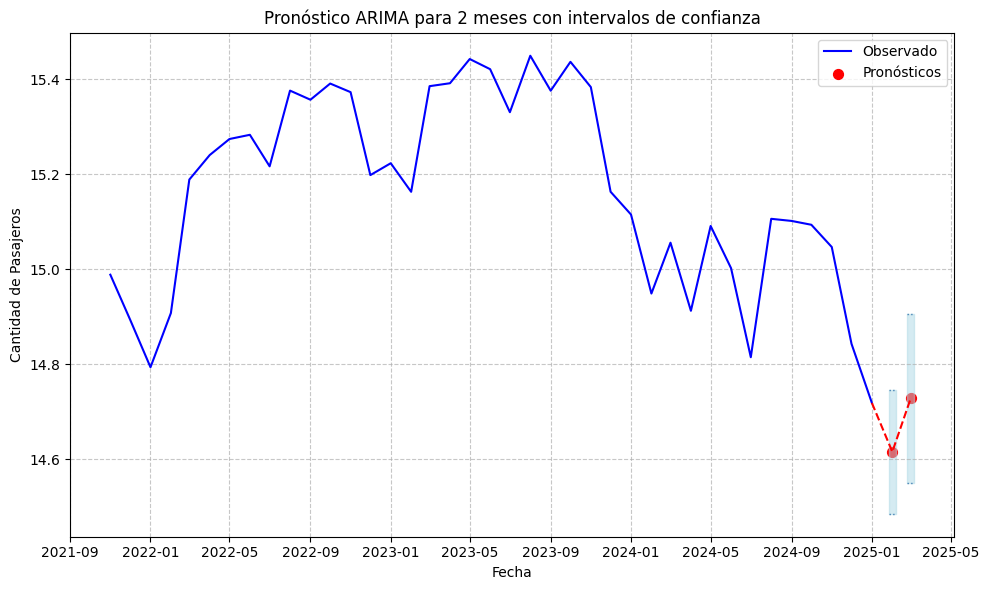

In [ ]:
#forecast. 2 meses
pax_forecast = pax_arima.forecast(steps=2)
print("Pronóstico para los próximos 2 meses:")
print(pax_forecast)
plt.figure(figsize=(10, 6))
plt.plot(pax, label='Observado', color='blue')

ultima_fecha = pax.index[-1]
fecha_pronostico1 = ultima_fecha + pd.DateOffset(months=1)
fecha_pronostico2 = ultima_fecha + pd.DateOffset(months=2)
fechas_pronostico = [fecha_pronostico1, fecha_pronostico2]


plt.scatter(fechas_pronostico, pax_forecast, color='red', marker='o', s=50, label='Pronósticos')
puntos_x = [ultima_fecha] + fechas_pronostico
puntos_y = [pax.iloc[-1]] + list(pax_forecast)
plt.plot(puntos_x, puntos_y, color='red', linestyle='--', linewidth=1.5)


pred_ci = pax_arima.get_prediction(start=len(pax), end=len(pax)+1).conf_int()
for i, fecha in enumerate(fechas_pronostico):
    limite_inferior = pred_ci.iloc[i, 0]
    limite_superior = pred_ci.iloc[i, 1]
    plt.fill_between(
        [fecha - timedelta(days=5), fecha + timedelta(days=5)],
        [limite_inferior, limite_inferior],
        [limite_superior, limite_superior],
        color='lightblue',
        alpha=0.5
    )
    plt.hlines(limite_inferior, fecha - timedelta(days=5), fecha + timedelta(days=5), 
               colors='steelblue', linestyles='dotted', linewidth=1)
    plt.hlines(limite_superior, fecha - timedelta(days=5), fecha + timedelta(days=5), 
               colors='steelblue', linestyles='dotted', linewidth=1)


plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title('Pronóstico ARIMA para 2 meses con intervalos de confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasajeros')
plt.tight_layout()
plt.show()

# Elasticidad

In [ ]:
#mco
X = data.drop('pax', axis=1) #data.drop elimina la columna pax y mantiene las demás 
y = data['pax']
X = sm.add_constant(X)
modelo_mco = sm.OLS(y, X).fit()
print(modelo_mco.summary())

                            OLS Regression Results                            
Dep. Variable:                    pax   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     83.27
Date:                dom, 16 mar 2025   Prob (F-statistic):           5.28e-16
Time:                        23:19:51   Log-Likelihood:                 47.203
No. Observations:                  39   AIC:                            -86.41
Df Residuals:                      35   BIC:                            -79.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.7277      2.710     -2.851      0.0

In [ ]:
#modelo dinamico
data_dyn = data.copy()
data_dyn['pax_lag1'] = data_dyn['pax'].shift(1) 
data_dyn = data_dyn.dropna() 

X_dyn = data_dyn[['kms', 'tbk real', 'pax_lag1']]
X_dyn = sm.add_constant(X_dyn)
y_dyn = data_dyn['pax']
modelo_dyn = sm.OLS(y_dyn, X_dyn).fit()
print("Modelo dinámico con 1 rezago:")
print(modelo_dyn.summary())

# Prueba de Durbin-Watson (equivalente a dwt)
dw_stat = durbin_watson(modelo_dyn.resid)
print(f"Estadístico Durbin-Watson: {dw_stat}")

Modelo dinámico con 1 rezago:
                            OLS Regression Results                            
Dep. Variable:                    pax   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     85.32
Date:                dom, 16 mar 2025   Prob (F-statistic):           6.71e-16
Time:                        23:22:15   Log-Likelihood:                 46.770
No. Observations:                  38   AIC:                            -85.54
Df Residuals:                      34   BIC:                            -78.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3374 

In [ ]:
#modelo dinamico con dos lag
data_dyn2 = data.copy()
data_dyn2['pax_lag1'] = data_dyn2['pax'].shift(1)
data_dyn2['pax_lag2'] = data_dyn2['pax'].shift(2)
data_dyn2 = data_dyn2.dropna()

X_dyn2 = data_dyn2[['kms', 'tbk real', 'pax_lag1', 'pax_lag2']]
X_dyn2 = sm.add_constant(X_dyn2)
y_dyn2 = data_dyn2['pax']
modelo_dyn2 = sm.OLS(y_dyn2, X_dyn2).fit()
print("Modelo dinámico con 2 rezagos:")
print(modelo_dyn2.summary())

dw_stat2 = durbin_watson(modelo_dyn2.resid)
print(f"Estadístico Durbin-Watson (modelo con 2 rezagos): {dw_stat2}")

Modelo dinámico con 2 rezagos:
                            OLS Regression Results                            
Dep. Variable:                    pax   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     73.41
Date:                dom, 16 mar 2025   Prob (F-statistic):           1.17e-15
Time:                        23:22:22   Log-Likelihood:                 49.241
No. Observations:                  37   AIC:                            -88.48
Df Residuals:                      32   BIC:                            -80.43
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.2177

In [ ]:
#fitted
valores_ajustados = modelo_dyn2.fittedvalues
pd.DataFrame(valores_ajustados, columns=['predicted']).to_excel("predicho.xlsx")

In [ ]:
n_fitted = len(valores_ajustados) 
pax_alineado = pax.iloc[-n_fitted:]

#df
df_plot = pd.DataFrame({
    'Fecha': pax_alineado.index,
    'pax_ts': pax_alineado.values,
    'fitted_ts': valores_ajustados.values
})

In [ ]:
#pivot large
df_plot_long = pd.melt(df_plot, id_vars=['Fecha'], value_vars=['pax_ts', 'fitted_ts'], 
                       var_name='Serie', value_name='Valor')

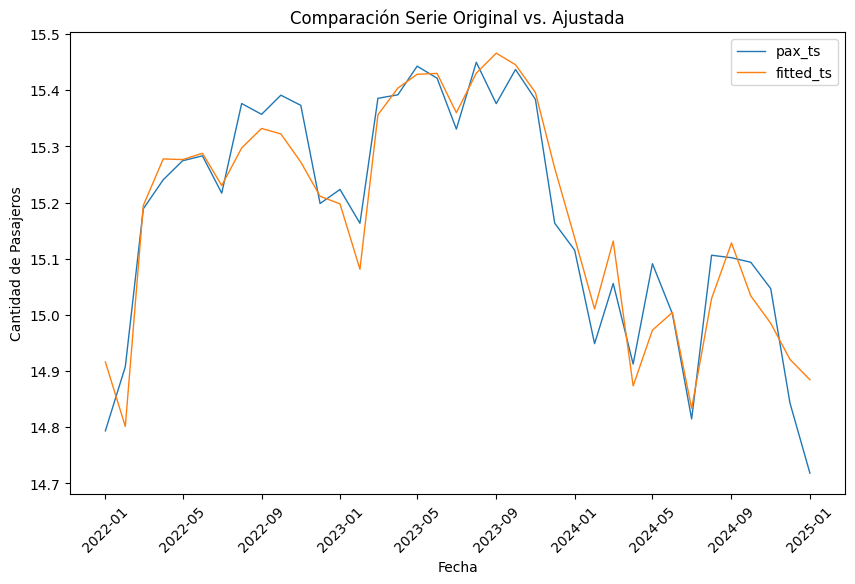

In [ ]:
#graph
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot_long, x='Fecha', y='Valor', hue='Serie', linewidth=1)
plt.title('Comparación Serie Original vs. Ajustada')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasajeros')
plt.legend(title='')
plt.xticks(rotation=45)
colores = {'pax_ts': 'black', 'fitted_ts': 'red'}
plt.show()